In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
run_trace = True # set to True to rerun all traces in full; otherwise loads saved

In [4]:
import scipy
scipy.__version__

'1.3.1'

In [5]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import lightkurve as lk

In [6]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [7]:
# Guesses from search
periods = np.array([17.47114])
t0s = np.array([1661.0628])
depths = 1e3 * np.array([0.0328])**2
durations = np.array([3.0]) / 24.0
letters = "bcd"
n_pl = len(periods)

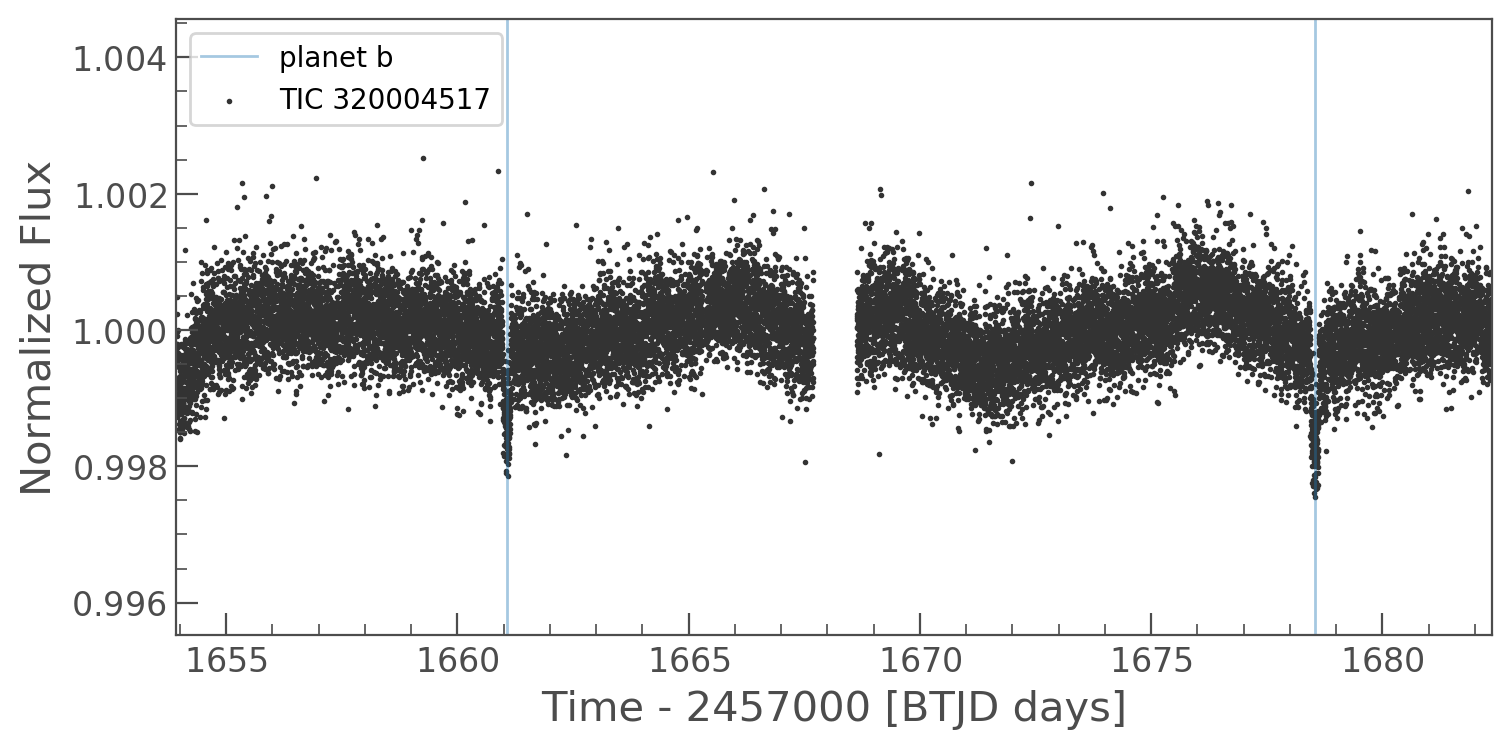

In [8]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC {0}'.format(tic_id))
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in np.arange(mn, mx + 1):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

In [9]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

In [10]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)

In [12]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[6.09623183] earthMass


In [13]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        log_period = pm.Normal("log_period", mu=np.log(periods[0]), sd=10.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0)
        
        log_ror = pm.Uniform("log_ror", lower=np.log(0.01), upper=np.log(0.1),
                             testval=0.5*np.log(1e-3*depths[0]))
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b_hat = xo.distributions.UnitUniform("b_hat")
        b = pm.Deterministic("b", b_hat * (1 + ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value[0]), sd=5)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        #ecc = xo.distributions.UnitUniform("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
            
        # RV jitter & an RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        model.light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) + mean_flux

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", model.gp.log_likelihood(y[mask] - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)
        
        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        bkg_noactivity = pm.Deterministic("bkg_noactivity", bkg_terms)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        if n_pl > 1:
            rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        else:
            rv_model = pm.Deterministic("rv_model", vrad + bkg)        
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))
        if n_pl > 1:
            pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
        else:
            pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

### 1-planet fit:

In [14]:
model, map_soln = build_model(fwhm=False, rv_trend_order=3)

optimizing logp for variables: [logs2]
9it [00:02,  3.94it/s, logp=-1.257588e+04]
message: Optimization terminated successfully.
logp: -13259.984782775615 -> -12575.878280260044
optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
53it [00:00, 80.43it/s, logp=-1.105619e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12575.878280260044 -> -11056.19351613284
optimizing logp for variables: [b_hat, log_ror]
10it [00:00, 20.24it/s, logp=-1.102679e+04]
message: Optimization terminated successfully.
logp: -11056.193516132837 -> -11026.79260999812
optimizing logp for variables: [t0, log_period]
135it [00:01, 128.97it/s, logp=-1.102653e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -11026.79260999812 -> -11026.532010948362
optimizing logp for variables: [log_m_pl]
11it [00:00, 15.17it/s, logp=-1.102444e+04] 
message: Optimization terminated successfully.
logp: -11026.532010948362 -> -11024.44018583542

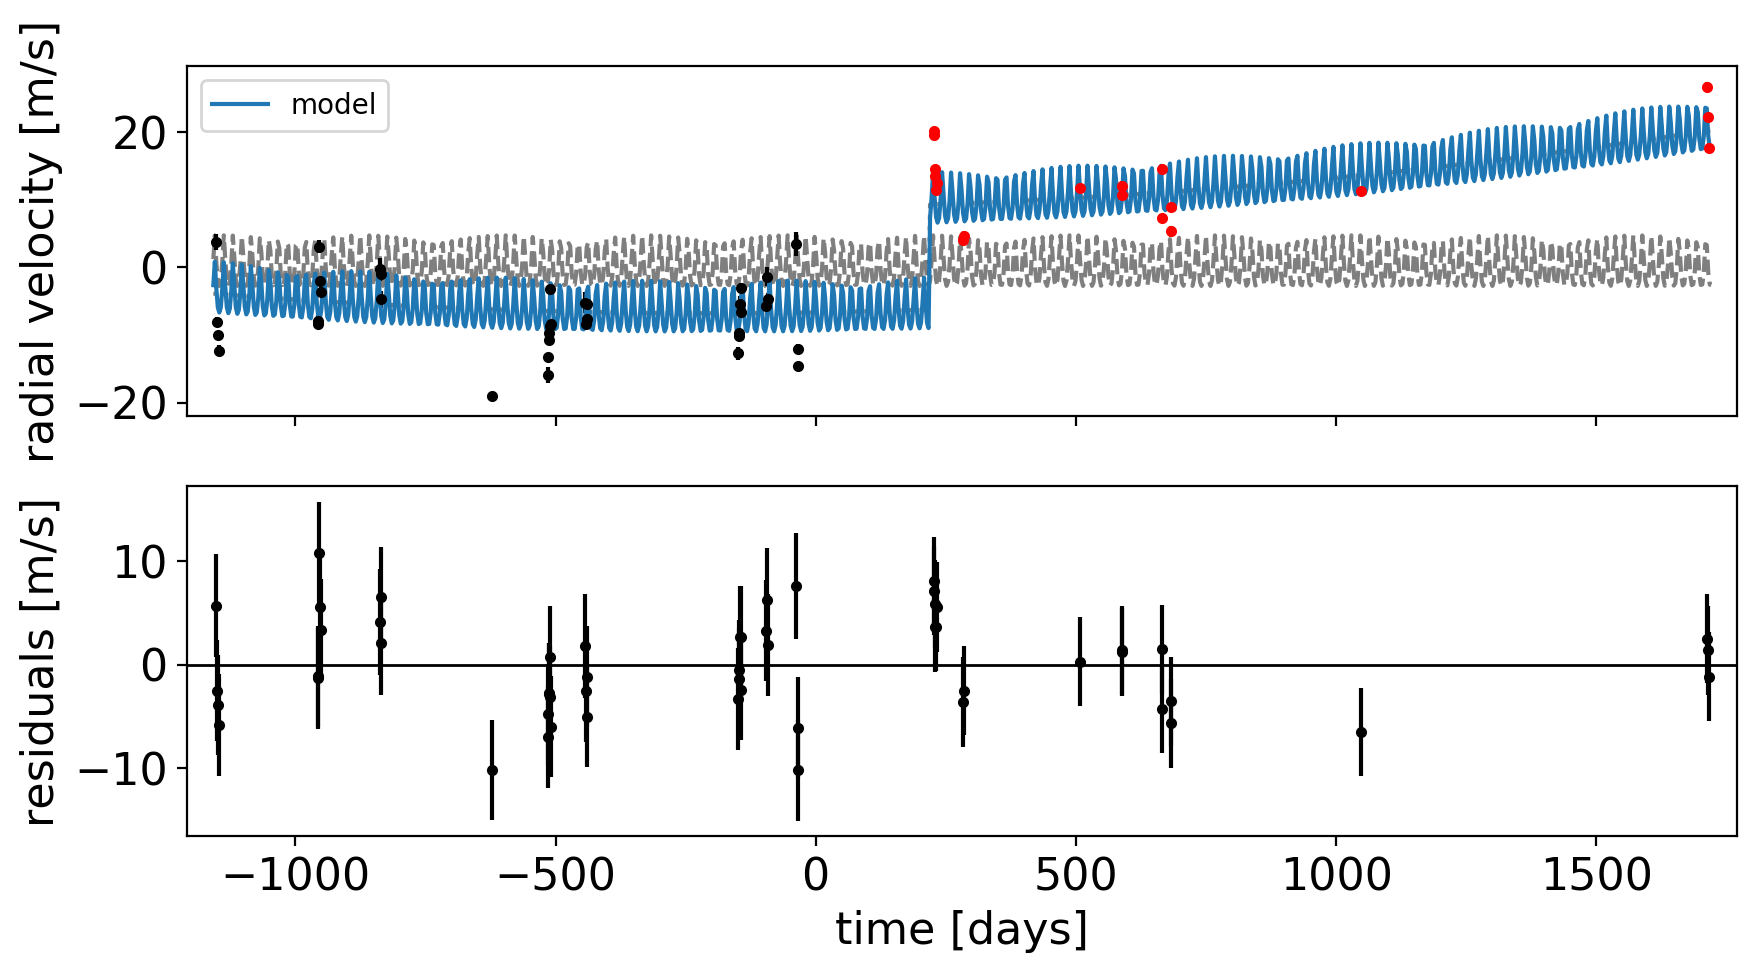

In [15]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv[~pug], y_rv[~pug], yerr=yerr_rv[~pug], fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug], yerr=yerr_rv[pug], fmt=".r")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err_pre = np.sqrt(yerr_rv[~pug]**2+np.exp(2*soln["logs_rv_pre"]))
    err_pug = np.sqrt(yerr_rv[pug]**2+np.exp(2*soln["logs_rv_pug"]))
    ax.errorbar(x_rv[~pug], y_rv[~pug] - soln["rv_model"][~pug], yerr=err_pre, fmt=".k")
    ax.errorbar(x_rv[pug], y_rv[pug] - soln["rv_model"][pug], yerr=err_pug, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min() - 50, t_rv.max() + 50)
    ax.set_xlabel("time [days]")

plot_rv_curve(map_soln)

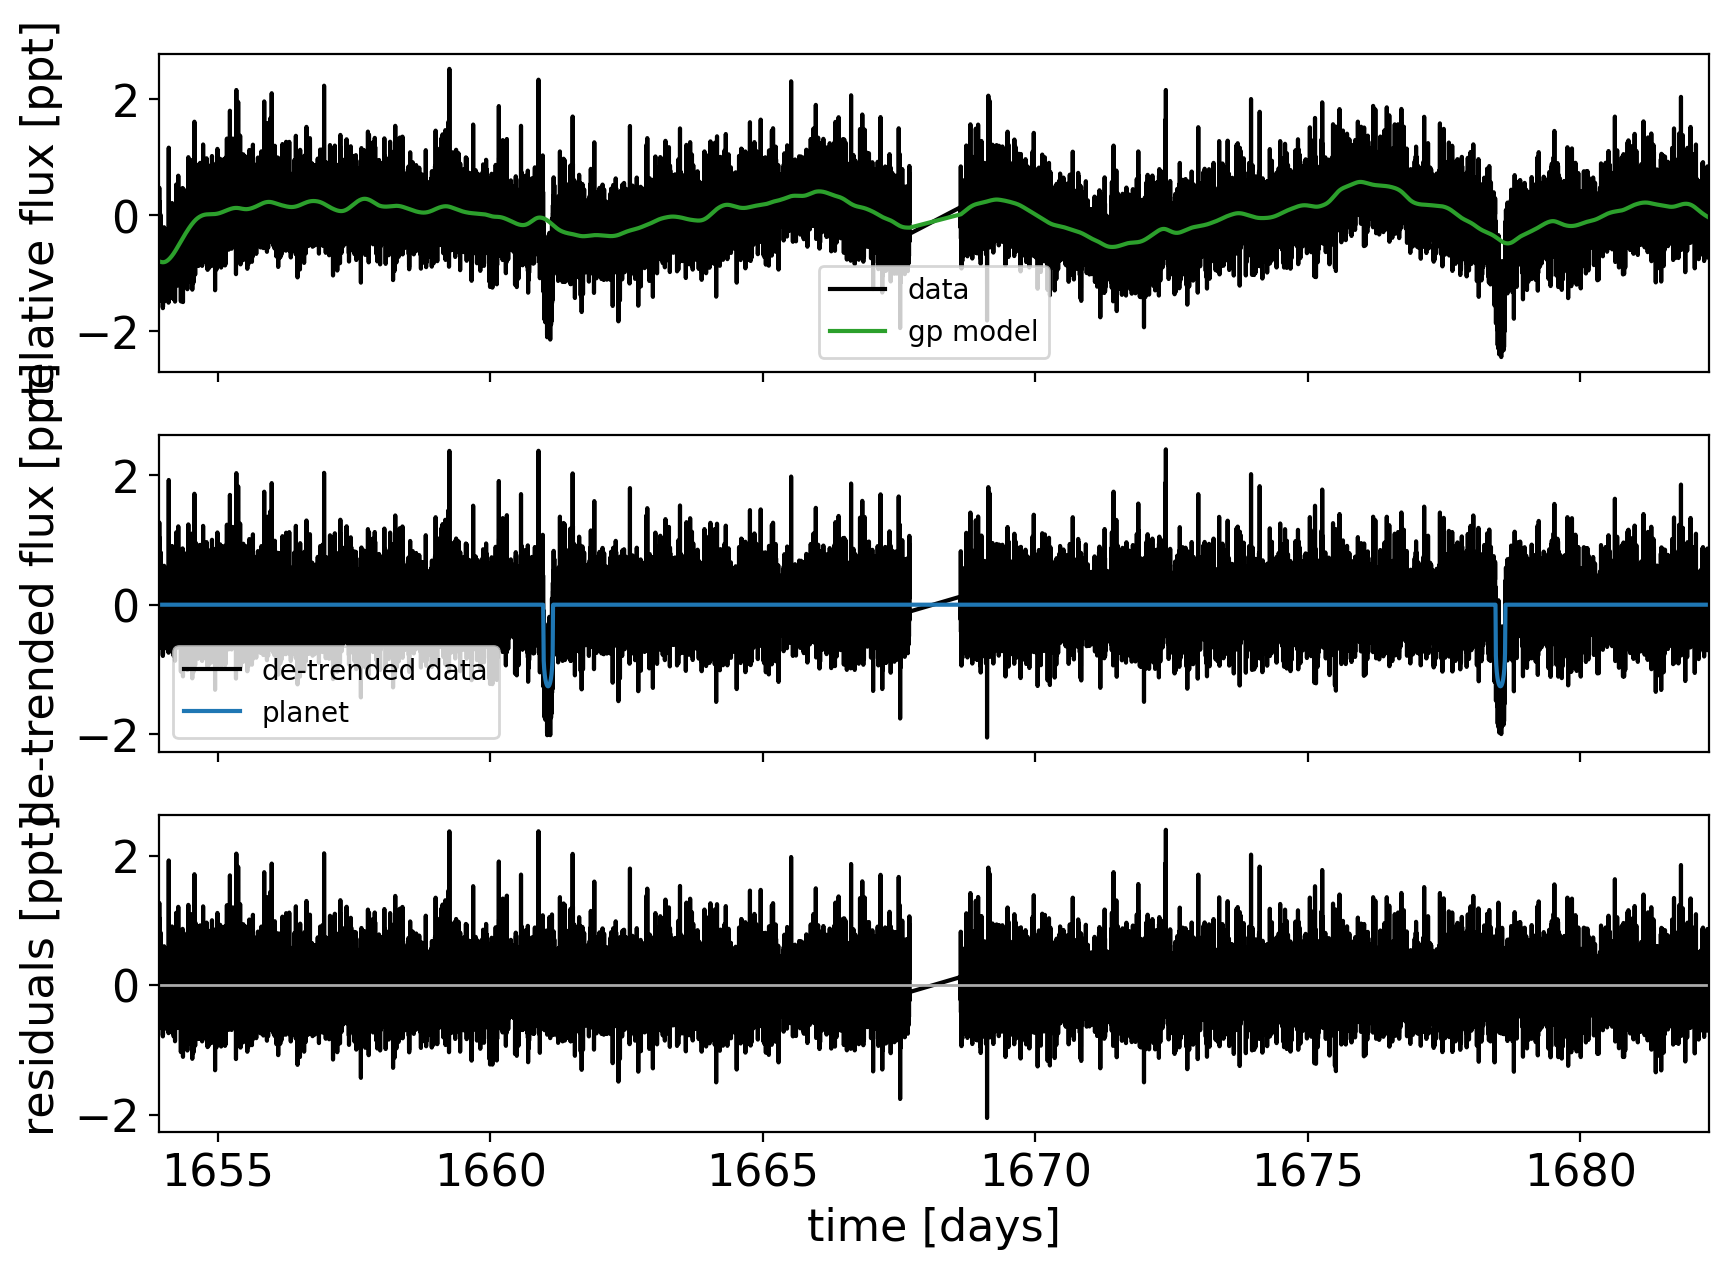

In [16]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], soln)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    ax.plot(x[mask], lc_mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + lc_mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(model, map_soln);

peak at 1.0383 +/- 0.0002 days with log(power) = 2.46
peak at 119.9255 +/- 1.8793 days with log(power) = 2.40
peak at 98.9630 +/- 2.2466 days with log(power) = 2.33
peak at 1.0101 +/- 0.0002 days with log(power) = 2.32
peak at 1.0257 +/- 0.0002 days with log(power) = 2.30


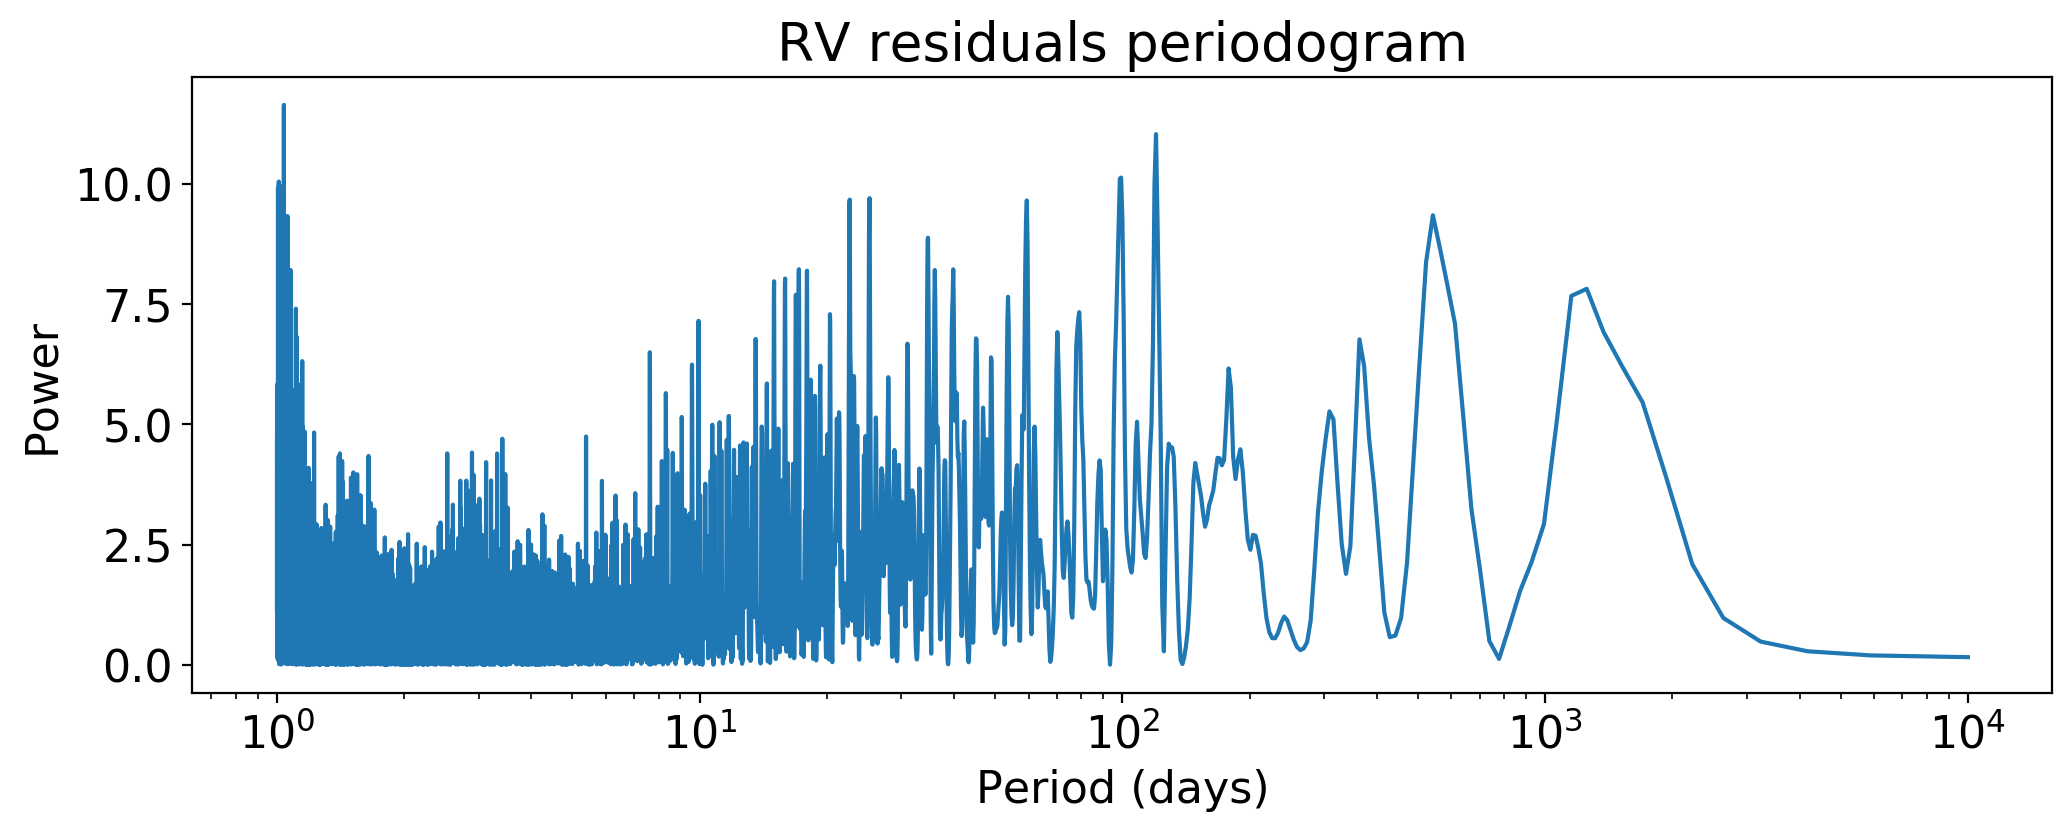

In [17]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./pg['periodogram'][0], pg['periodogram'][1])
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
for p in pg['peaks']:
    print('peak at {0:.4f} +/- {1:.4f} days with log(power) = {2:.2f}'.format(p['period'], 
                                                                              p['period_uncert'], p['log_power']))

In [18]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl')

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend, offset_pug, logs_rv_pug, logs_rv_pre, logpower, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, log_m_pl, b_hat, log_ror, t0, log_period, u_star, mean_flux, mr_star]
Sampling 2 chains: 100%|██████████| 4000/4000 [14:46<00:00,  4.51draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [22]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "bkg_noactivity", 
                                              "rv_model", "rv_model_pred", "bkg_pred")])

    s.to_pickle('summary_1pl.p')
else:
    s = pd.read_pickle('summary_1pl.p')
    
s

mean        sd      mc_error      hpd_2.5     hpd_97.5  \
mean_flux      -0.019700  0.065119  2.022021e-03    -0.142417     0.113058   
log_period      2.860555  0.000091  2.135950e-06     2.860394     2.860760   
logs2          -1.751254  0.010388  2.394788e-04    -1.771947    -1.731591   
logw0           0.735735  0.152713  3.482767e-03     0.423626     1.020496   
logpower        0.028722  0.306630  5.984116e-03    -0.585446     0.620061   
logs_rv_pre     1.604650  0.127427  2.254868e-03     1.354468     1.843744   
logs_rv_pug     1.585703  0.181434  4.289742e-03     1.257686     1.958421   
offset_pug     15.550450  0.402007  1.169734e-02    14.824929    16.320145   
trend__0        0.000003  0.000001  3.071340e-08     0.000001     0.000006   
trend__1        0.001667  0.001091  2.450166e-05    -0.000558     0.003662   
trend__2       -6.900065  0.978916  2.138536e-02    -8.845838    -5.037923   
mr_star__0      0.982332  0.001575  3.031295e-05     0.978973     0.985096   
mr_star__1      0.957368  0.006303  1.282875e-04     0.945491     0.969622   
m_star          0.982332  0.001575  3.031295e-05     0.978973     0.985096   
r_star          0.957368  0.006303  1.282875e-04     0.945491     0.969622   
u_star__0       0.394107  0.228982  6.985461e-03     0.009623     0.808473   
u_star__1       0.227167  0.340512  1.140902e-02    -0.361800     0.824159   
period         17.471217  0.001594  3.731724e-05    17.468407    17.474796   
t0           1661.062863  0.001026  2.184046e-05  1661.060934  1661.065010   
log_ror        -3.421564  0.025160  1.008268e-03    -3.463935    -3.362962   
ror             0.032672  0.000824  3.341690e-05     0.031306     0.034633   
b_hat           0.287639  0.163384  8.101762e-03     0.000243     0.576368   
b               0.297114  0.168923  8.382093e-03     0.000251     0.596280   
r_pl            0.031279  0.000819  3.305799e-05     0.029633     0.032943   
log_m_pl        2.032658  0.673460  2.621784e-02     0.557337     3.105204   
m_pl            9.202473  4.951848  1.699223e-01     1.028464    17.784865   
ecc_alpha       1.115363  0.103498  2.170346e-03     0.909459     1.313738   
ecc_beta        3.105913  0.287796  5.777582e-03     2.545009     3.676129   
ecc__0          0.145313  0.107090  4.344919e-03     0.000499     0.342935   
omega           0.254636  1.373011  5.063006e-02    -2.409578     3.137155   
logS0          -2.914216  0.417104  9.861766e-03    -3.636335    -2.035827   

                   n_eff      Rhat  
mean_flux     681.270746  1.000248  
log_period   1773.272345  0.999537  
logs2        1896.281815  0.999529  
logw0        1901.884478  0.999588  
logpower     2809.436673  0.999842  
logs_rv_pre  2584.862499  0.999503  
logs_rv_pug  1802.165996  1.001729  
offset_pug    570.605466  1.000714  
trend__0      739.513920  0.999793  
trend__1     1933.068885  0.999534  
trend__2     1976.904762  0.999504  
mr_star__0   2791.155854  0.999546  
mr_star__1   2908.851326  0.999516  
m_star       2791.155854  0.999546  
r_star       2908.851326  0.999516  
u_star__0    1144.142752  0.999724  
u_star__1     794.265471  1.001769  
period       1773.322487  0.999537  
t0           1829.116109  0.999500  
log_ror       354.243473  1.000623  
ror           343.558575  1.000731  
b_hat         229.836674  1.002211  
b             229.317227  1.002220  
r_pl          349.448880  1.000568  
log_m_pl      490.445204  1.008959  
m_pl          700.437726  1.004884  
ecc_alpha    2317.137358  0.999524  
ecc_beta     2530.202626  0.999858  
ecc__0        502.150084  1.001804  
omega         593.293577  0.999504  
logS0        1655.763519  0.999500

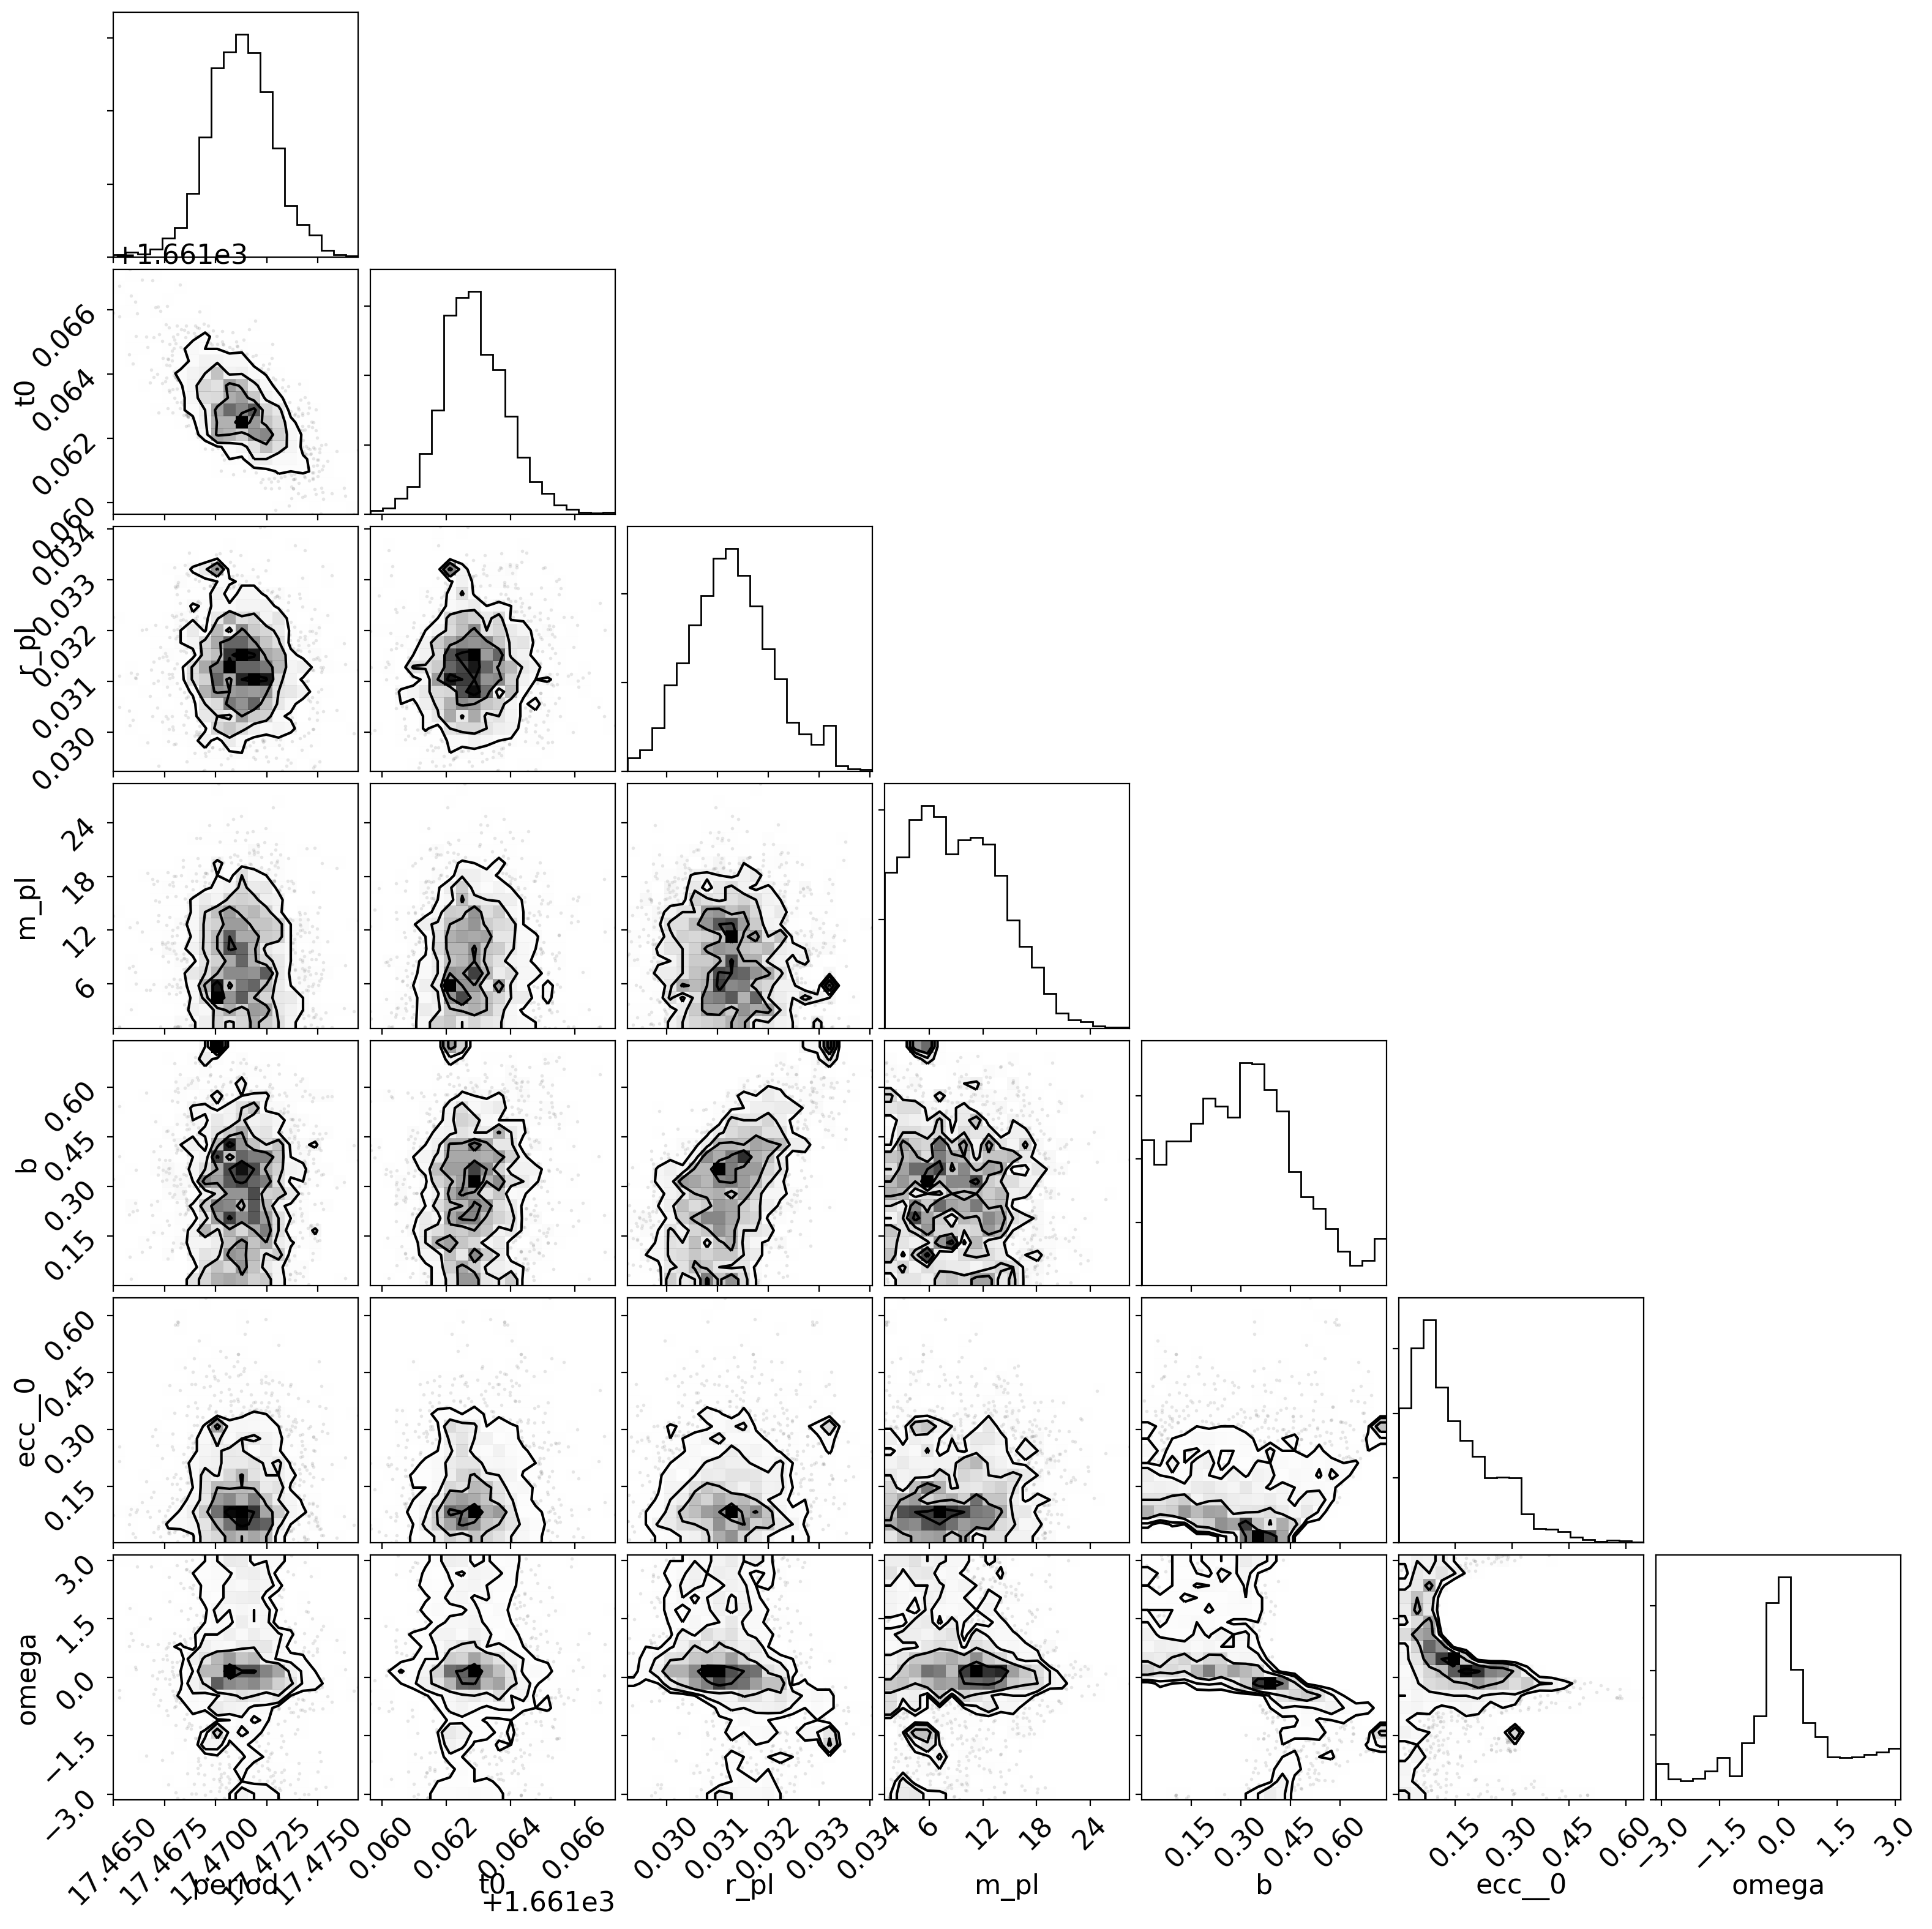

In [23]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

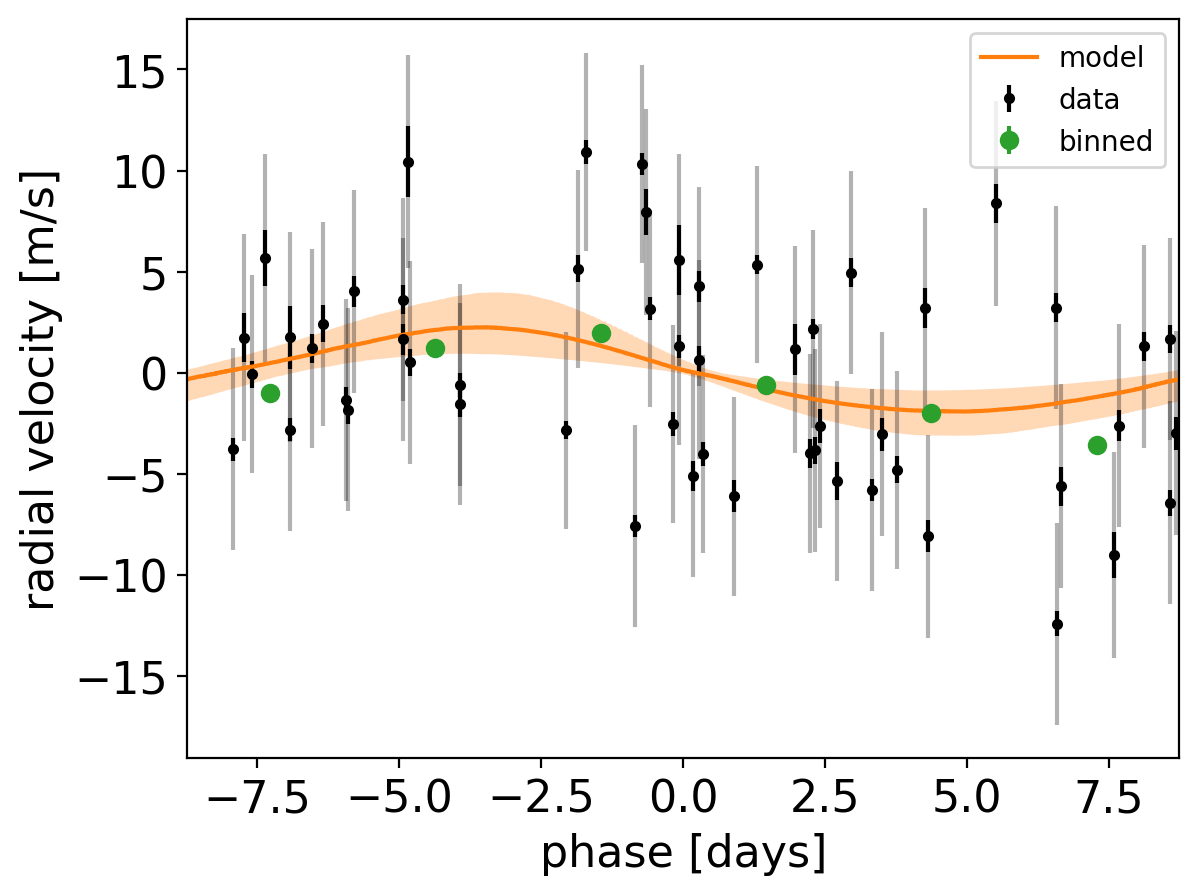

In [24]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
plt.savefig('rvphased_1pl.pdf');

### 1-planet fit with FWHM correlation:

In [25]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [logs2]
9it [00:00, 17.15it/s, logp=-1.258255e+04] 
message: Optimization terminated successfully.
logp: -13266.653621380658 -> -12582.547118865086
optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
53it [00:00, 78.62it/s, logp=-1.106286e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -12582.547118865086 -> -11062.862354737883
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
14it [00:00, 16.90it/s, logp=-1.106069e+04] 
message: Optimization terminated successfully.
logp: -11062.862354737883 -> -11060.69234432154
optimizing logp for variables: [b_hat, log_ror]
10it [00:00, 19.93it/s, logp=-1.103129e+04]
message: Optimization terminated successfully.
logp: -11060.692344321536 -> -11031.291448928596
optimizing logp for variables: [t0, log_period]
89it [00:00, 103.20it/s, logp=-1.103102e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -11031.291448928592 

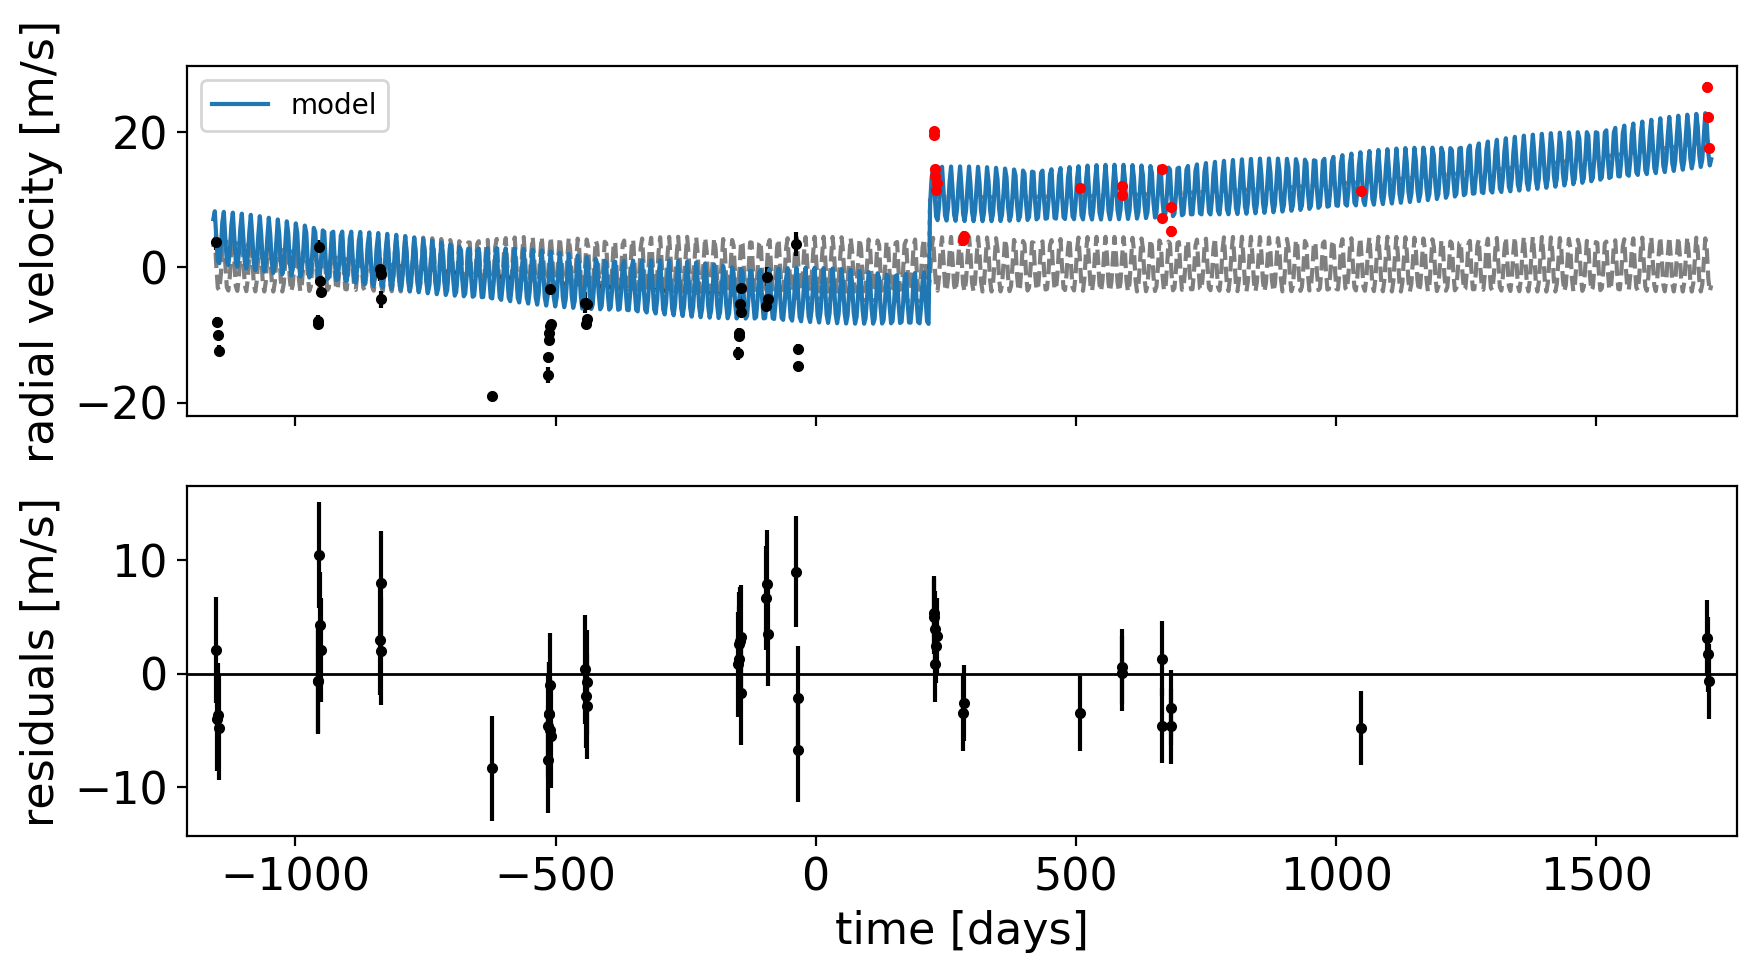

In [26]:
plot_rv_curve(map_soln);

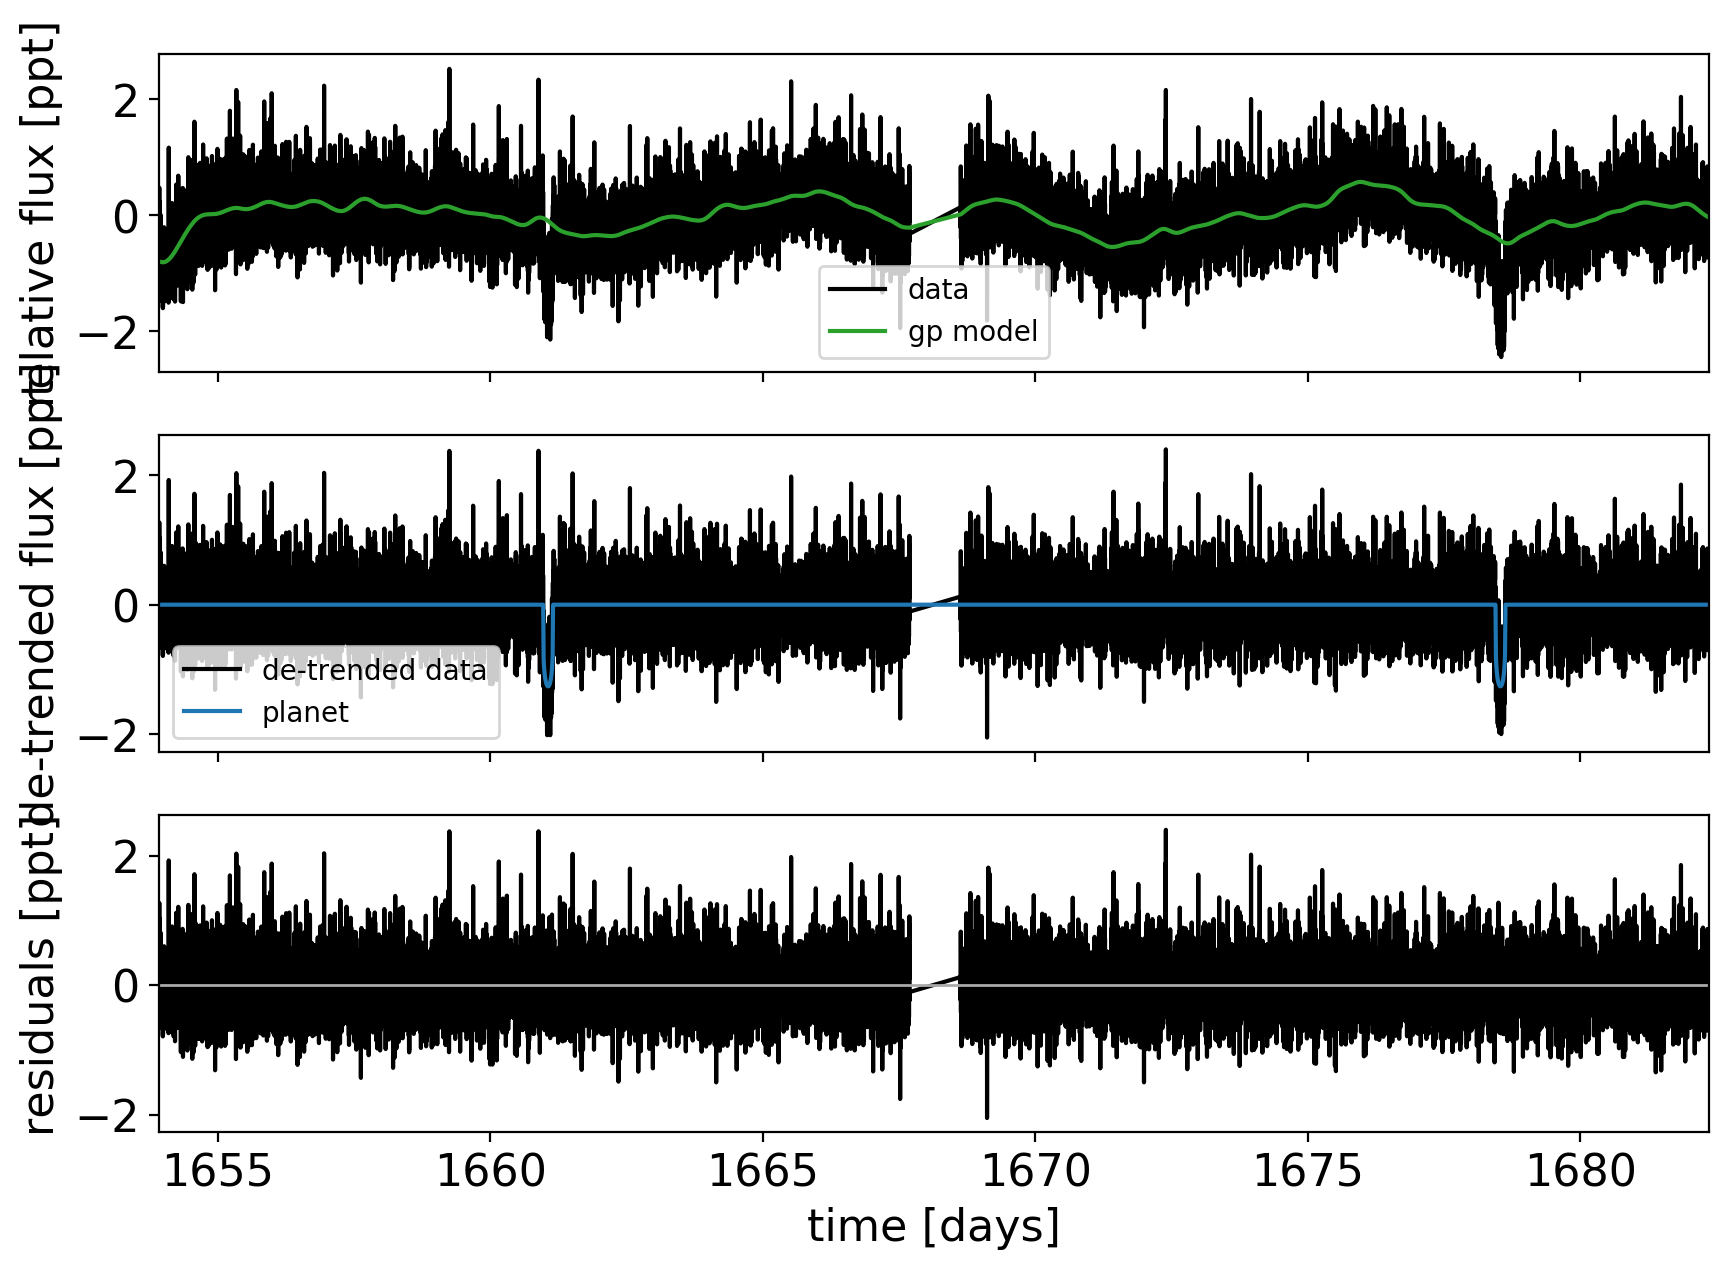

In [27]:
plot_light_curve(model, map_soln);

peaks at:
1.01 days
120.07 days
1.02 days
1.04 days
1.01 days
53.62 days
1.04 days
1.01 days
1.06 days
1.02 days


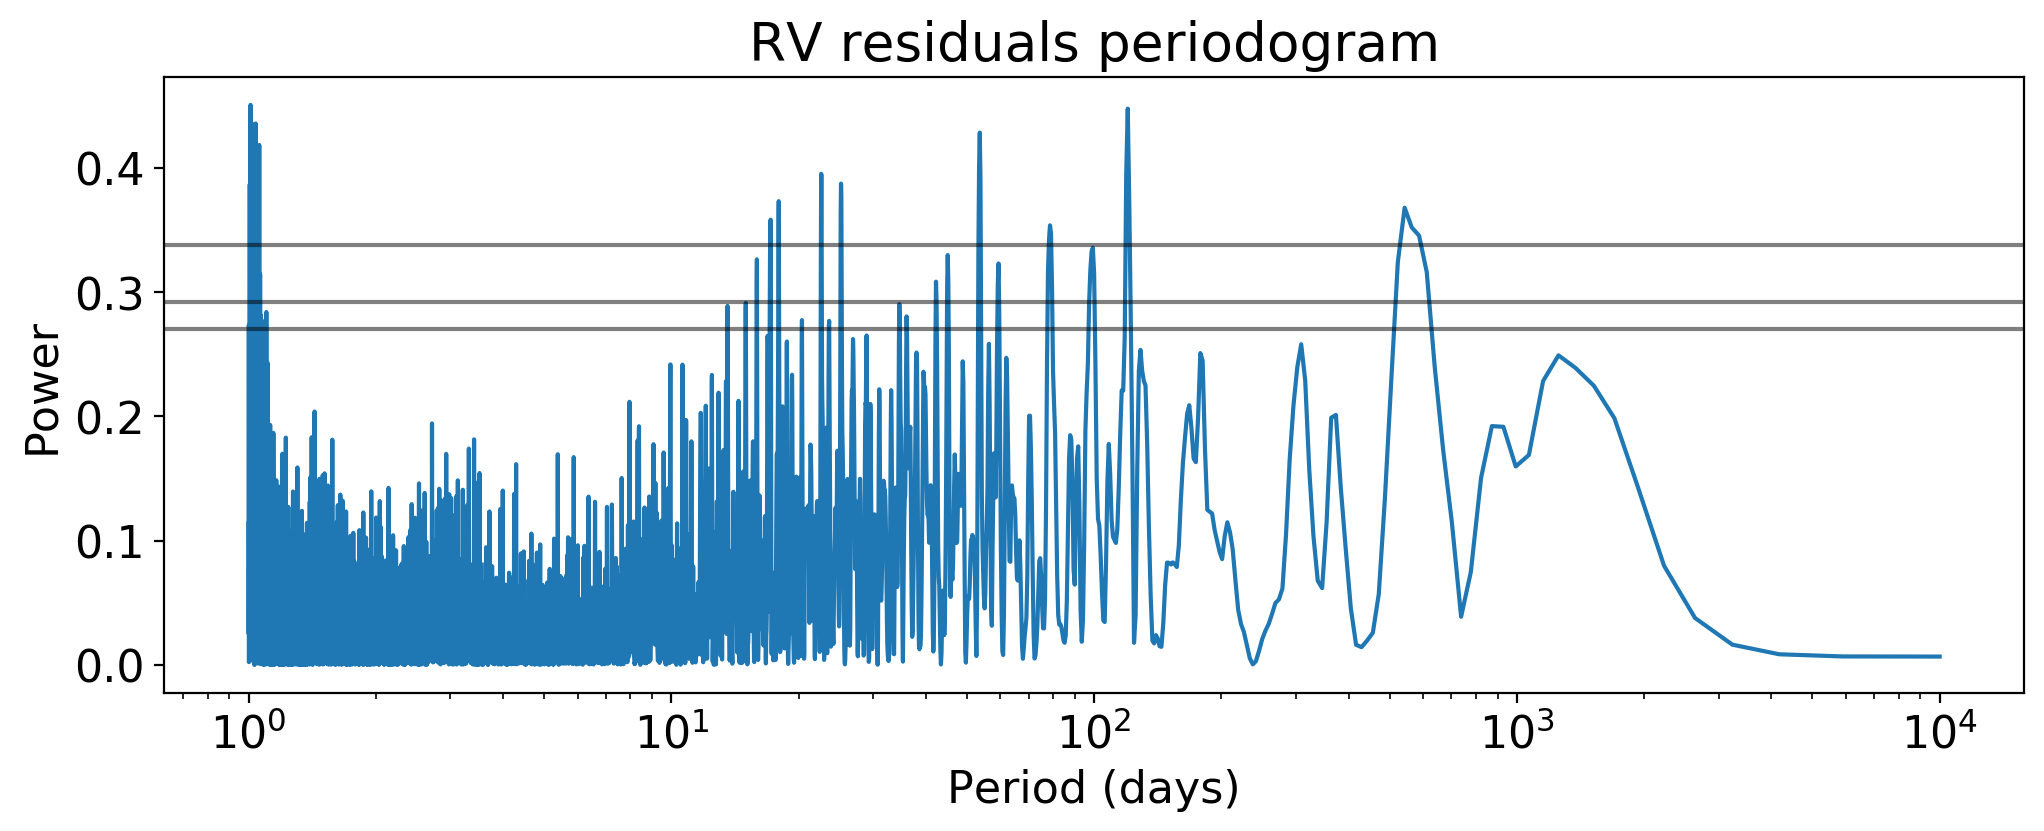

In [34]:
pg = xo.lomb_scargle_estimator(x_rv, y_rv - map_soln["rv_model"], yerr=yerr_rv, 
                               min_period=1, max_period=1e4, max_peaks=5)
    
from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv - map_soln["rv_model"], yerr_rv)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV residuals periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

In [29]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='pymc_1pl_wfwhm', overwrite=True)   
else:
    with model:
        trace = pm.load_trace('pymc_1pl_wfwhm')

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend_fwhm, offset_pug_fwhm, trend, offset_pug, logs_rv_pug, logs_rv_pre, logpower, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, log_m_pl, b_hat, log_ror, t0, log_period, u_star, mean_flux, mr_star]
Sampling 2 chains: 100%|██████████| 4000/4000 [15:14<00:00,  4.37draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [30]:
if run_trace:
    s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "bkg_noactivity", 
                                              "rv_model", "rv_model_pred", "bkg_pred")])
    s.to_pickle('summary_1pl_wfwhm.p')
else:
    s = pd.read_pickle('summary_1pl_wfwhm.p')
    
s

mean            sd      mc_error      hpd_2.5  \
mean_flux          -0.019008  6.151556e-02  1.410296e-03    -0.141024   
log_period          2.860565  8.843355e-05  2.107023e-06     2.860398   
logs2              -1.751740  1.019196e-02  2.044065e-04    -1.774325   
logw0               0.742467  1.489497e-01  3.826974e-03     0.432192   
logpower            0.032777  3.012085e-01  6.656675e-03    -0.544225   
logs_rv_pre         1.559127  1.335397e-01  3.174080e-03     1.296889   
logs_rv_pug         1.332157  2.000551e-01  5.212364e-03     0.947106   
offset_pug         15.415669  4.036482e-01  9.193938e-03    14.640639   
trend__0            0.000004  9.876837e-07  2.471211e-08     0.000002   
trend__1           -0.002137  1.863362e-03  5.048817e-05    -0.005624   
trend__2           -4.648748  7.162483e+00  1.739195e-01   -18.787448   
offset_pug_fwhm     3.092419  2.315677e+00  9.144127e-02    -1.069986   
trend_fwhm__0       1.505725  5.774099e-01  2.096169e-02     0.453555   
trend_fwhm__1      -4.441929  7.284310e+00  1.753620e-01   -18.825819   
mr_star__0          0.982400  1.571130e-03  3.510403e-05     0.979330   
mr_star__1          0.957208  6.414918e-03  1.465202e-04     0.944336   
m_star              0.982400  1.571130e-03  3.510403e-05     0.979330   
r_star              0.957208  6.414918e-03  1.465202e-04     0.944336   
u_star__0           0.398349  2.175052e-01  5.068660e-03     0.014307   
u_star__1           0.212653  3.315535e-01  8.854256e-03    -0.358685   
period             17.471398  1.545046e-03  3.681194e-05    17.468483   
t0               1661.062786  1.063239e-03  2.847577e-05  1661.060675   
log_ror            -3.422233  2.333101e-02  7.431273e-04    -3.465585   
ror                 0.032648  7.631136e-04  2.454990e-05     0.031255   
b_hat               0.275225  1.468849e-01  5.941322e-03     0.000159   
b                   0.284267  1.518155e-01  6.142272e-03     0.000164   
r_pl                0.031252  7.810498e-04  2.541330e-05     0.029683   
log_m_pl            2.471130  5.019179e-01  2.584690e-02     1.385198   
m_pl               13.070105  4.961808e+00  1.956515e-01     2.550278   
ecc_alpha           1.108846  9.993241e-02  2.145495e-03     0.908668   
ecc_beta            3.115116  3.101902e-01  6.783902e-03     2.540415   
ecc__0              0.093982  6.829914e-02  2.344003e-03     0.000283   
omega               0.437265  1.608686e+00  5.486492e-02    -2.740550   
logS0              -2.937091  4.318075e-01  1.094070e-02    -3.775849   

                    hpd_97.5        n_eff      Rhat  
mean_flux           0.102211  1648.287450  0.999547  
log_period          2.860742  1399.185490  0.999972  
logs2              -1.733522  2326.218167  0.999950  
logw0               1.016479  1273.660555  0.999620  
logpower            0.657284  2046.537523  0.999603  
logs_rv_pre         1.817587  1502.883602  1.002165  
logs_rv_pug         1.730980  1353.783774  0.999751  
offset_pug         16.166521  2016.012873  1.001550  
trend__0            0.000006  1308.085769  0.999777  
trend__1            0.001566  1150.639868  1.000255  
trend__2            9.039541  1942.535625  0.999667  
offset_pug_fwhm     7.748277   554.122226  1.000418  
trend_fwhm__0       2.662081   643.035010  0.999971  
trend_fwhm__1       9.408692  1855.527317  0.999570  
mr_star__0          0.985494  1598.695205  0.999502  
mr_star__1          0.969012  1633.081906  0.999519  
m_star              0.985494  1598.695205  0.999502  
r_star              0.969012  1633.081906  0.999519  
u_star__0           0.767891  1660.862459  0.999830  
u_star__1           0.791080  1202.442737  1.000562  
period             17.474486  1399.209785  0.999973  
t0               1661.064817  1051.868720  0.999969  
log_ror            -3.375920   729.033920  1.002076  
ror                 0.034187   704.730075  1.002151  
b_hat               0.498974   533.918099  0.999509  
b                   0.515738   533.489565  0.999510  
r_pl      

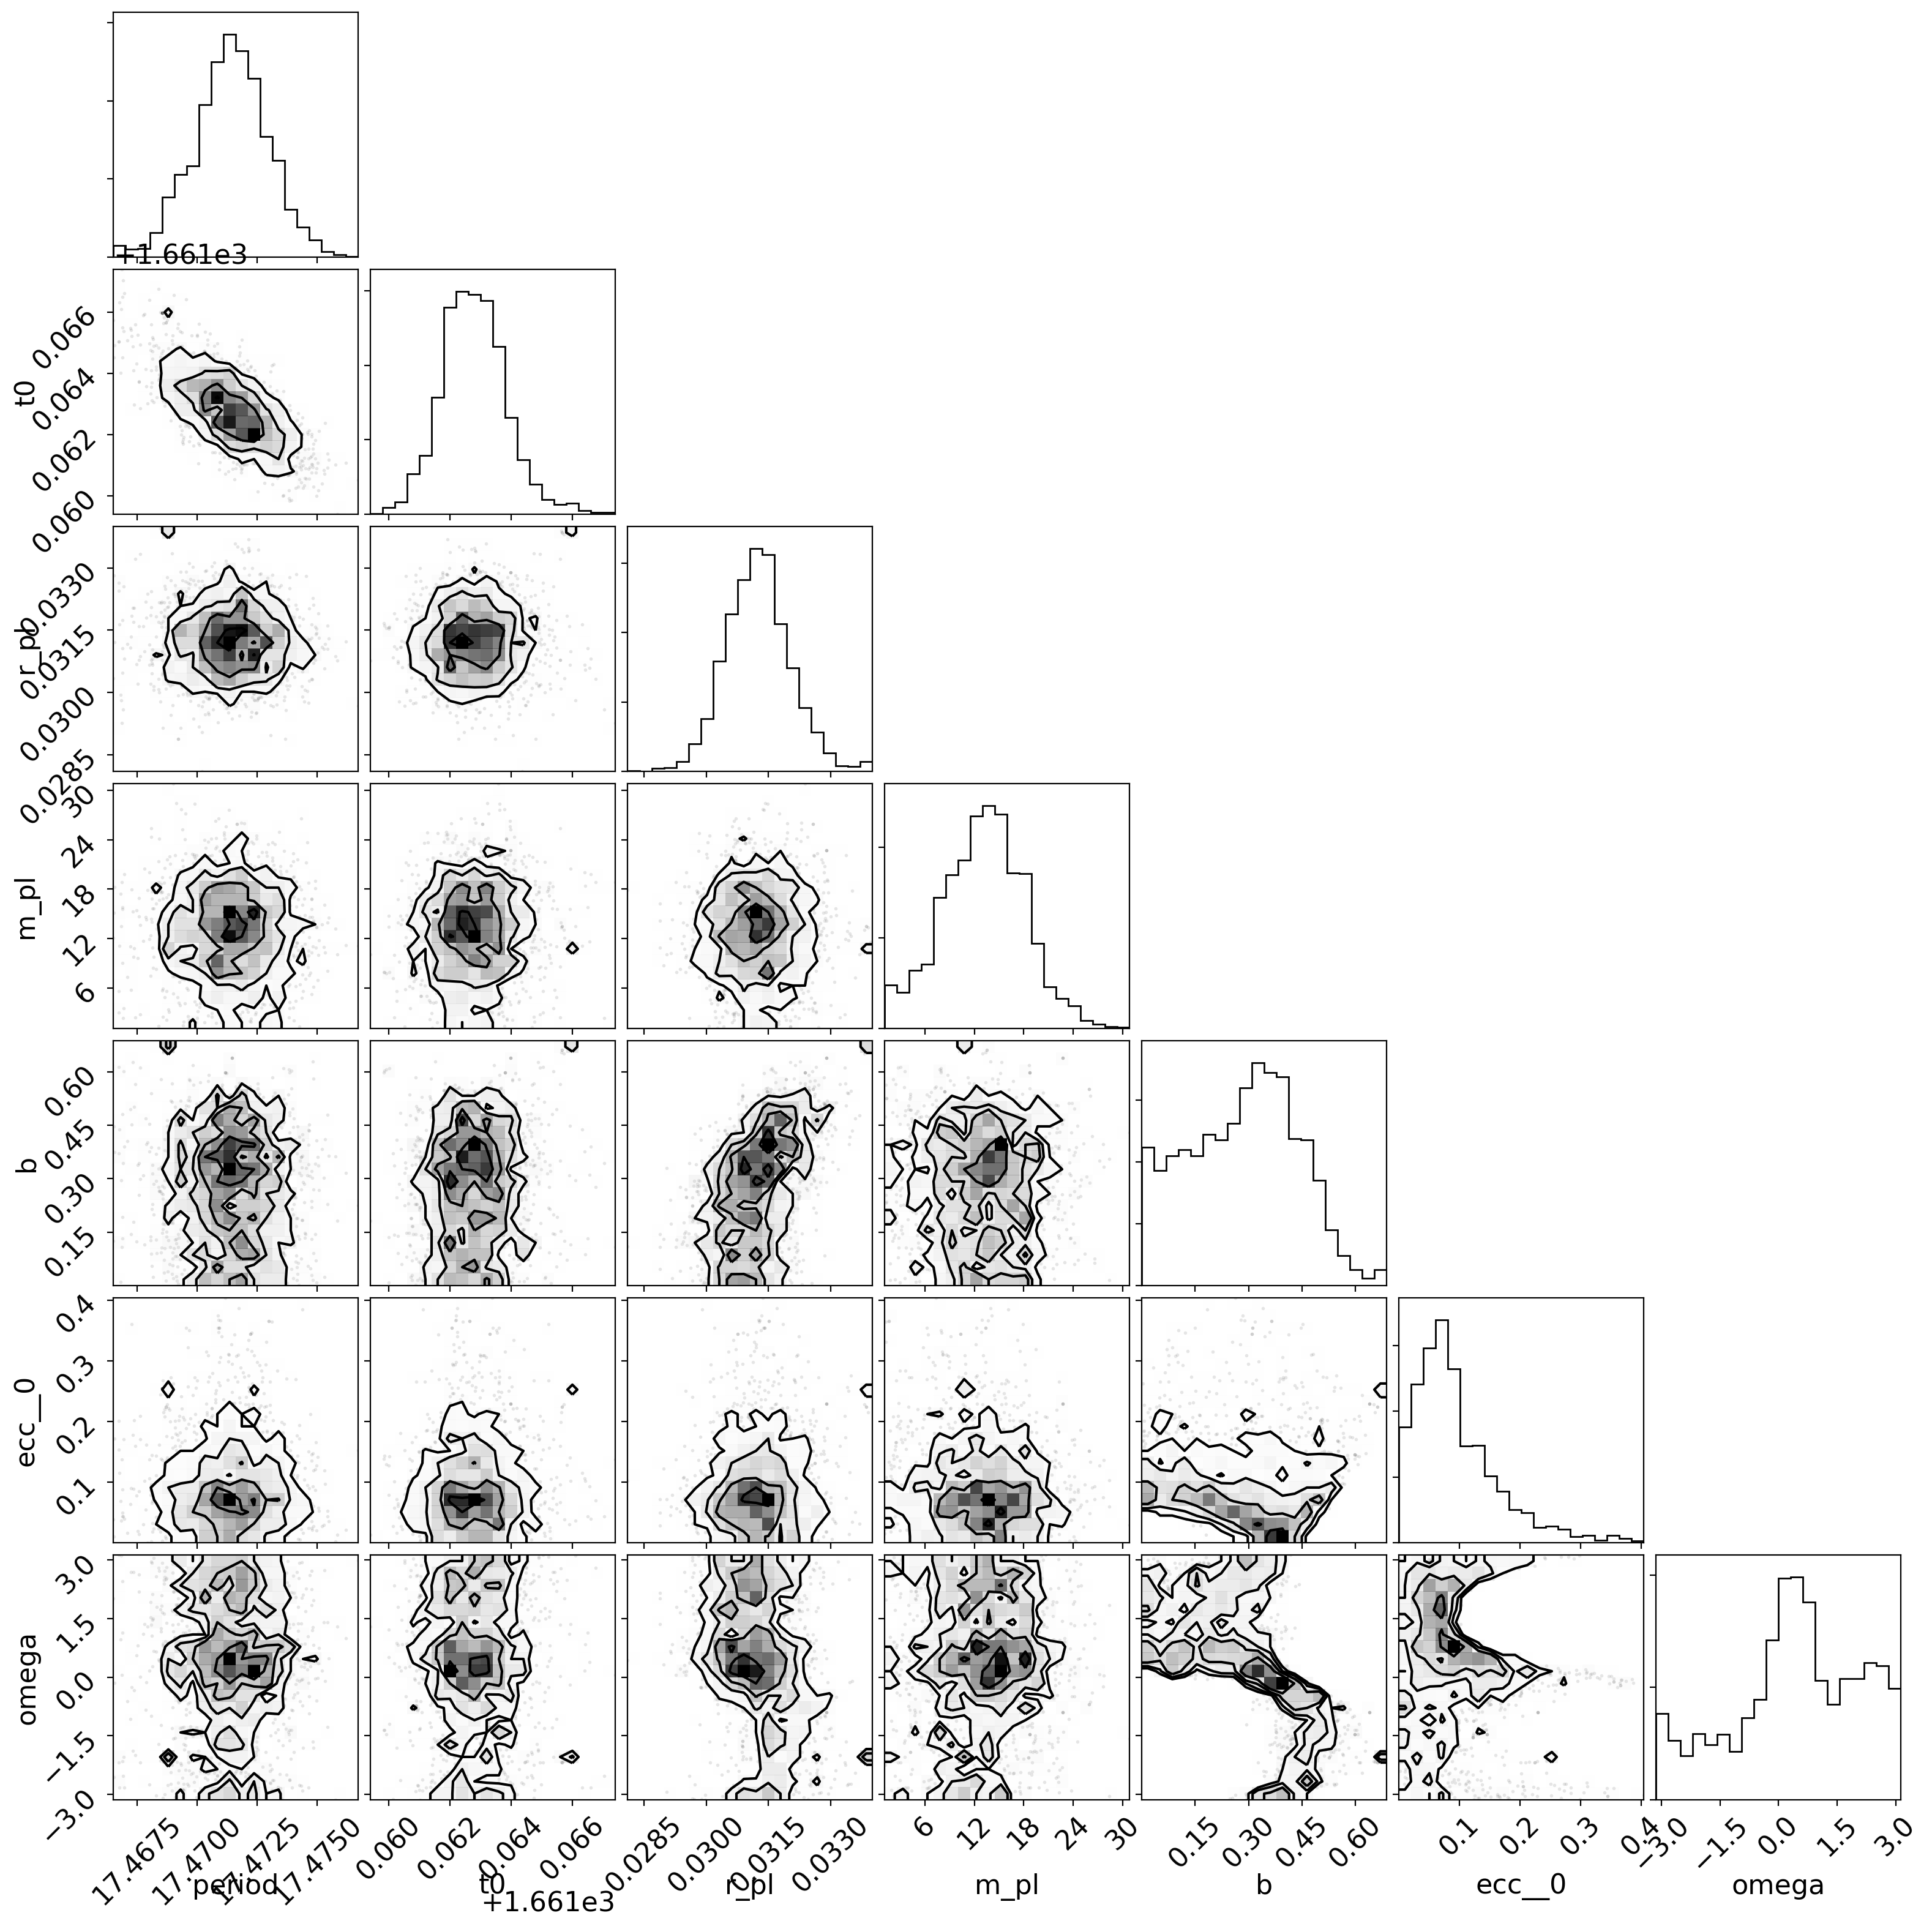

In [31]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

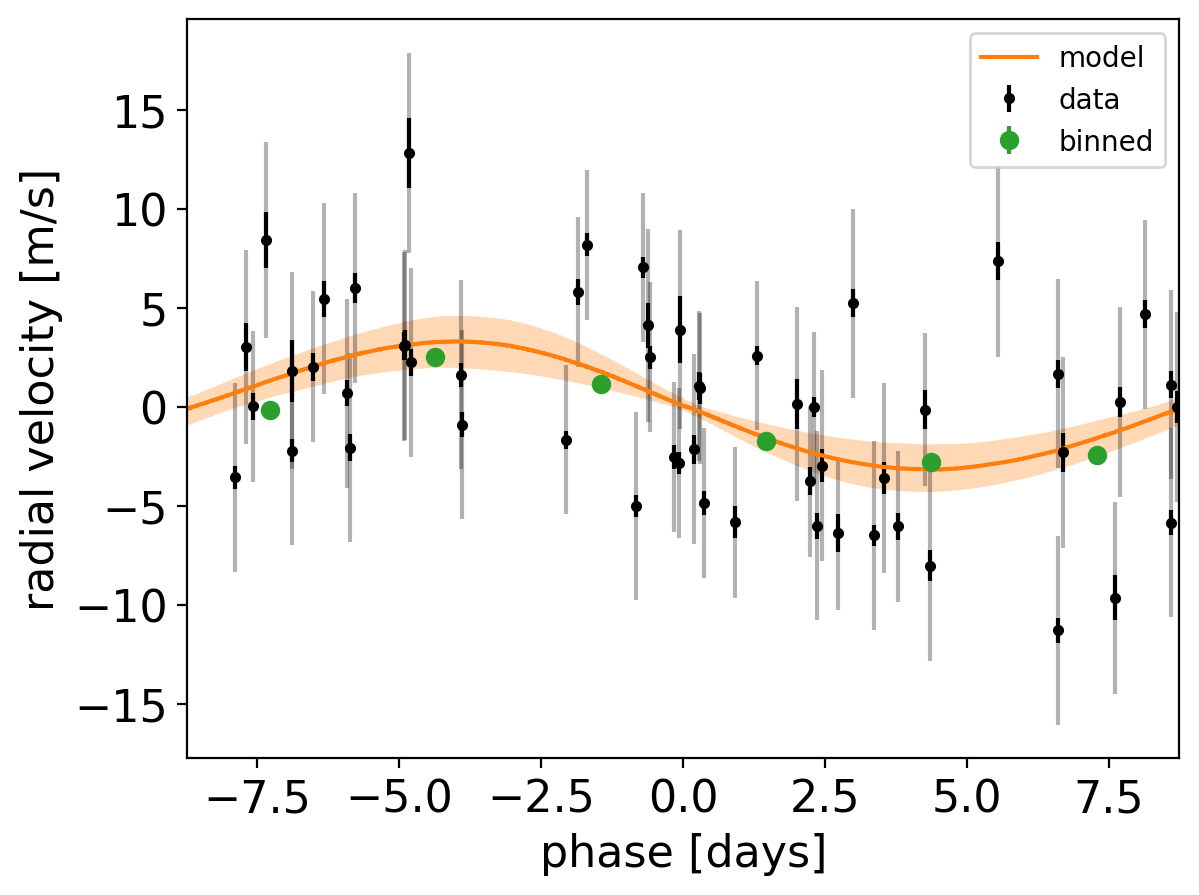

In [32]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
plt.savefig('rvphased_1pl_wfwhm.pdf');

Text(0.5, 0, 'time [days]')

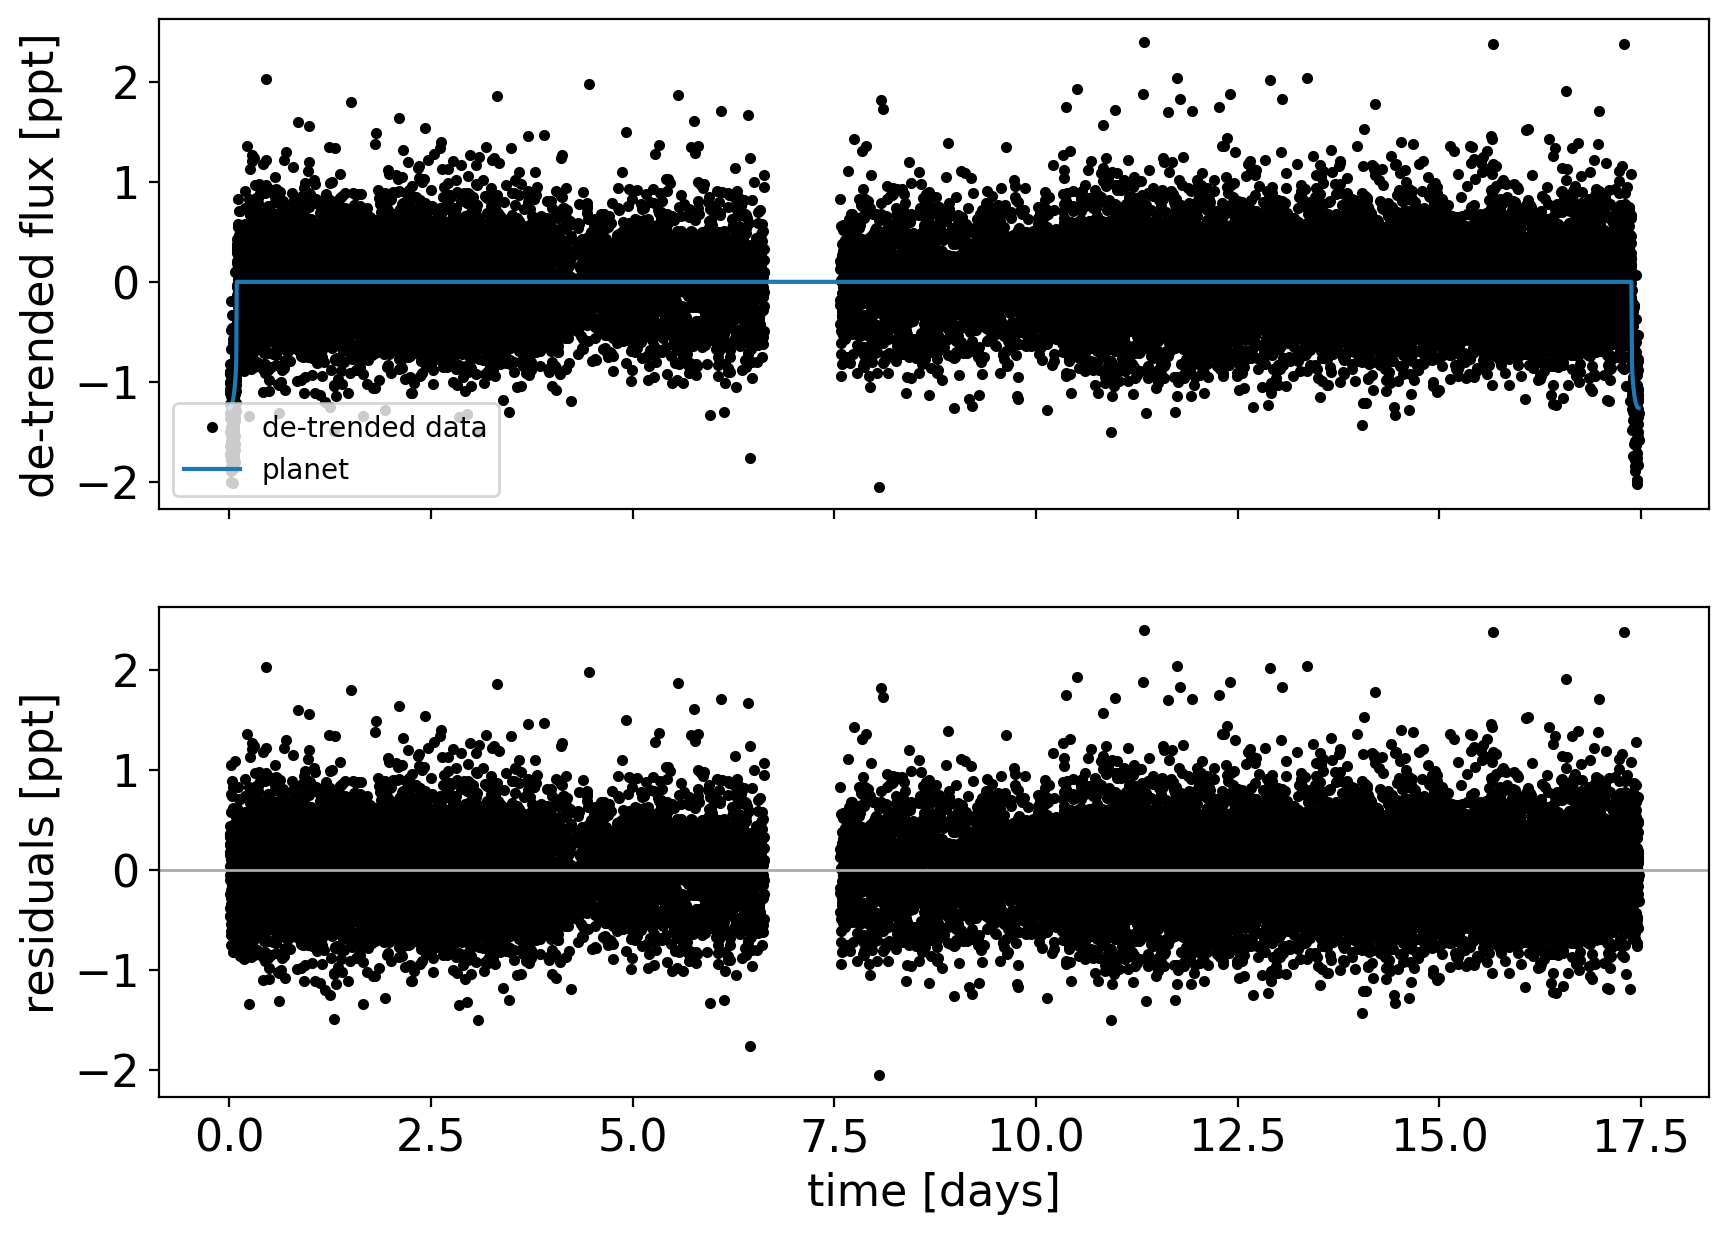

In [33]:
    fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], map_soln)


    ax = axes[0]
    xs = ((x - map_soln['t0']) % map_soln['period'])
    inds = np.argsort(xs)
    xs = xs[inds]
    ys = (y - gp_mod)[inds]
    resids = ys - lc_mod[inds]
    mod = lc_mod[inds]
    
    ax.plot(xs, ys, "k.", label="de-trended data")
    ax.plot(xs, mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    ax.plot(xs, resids, "k.")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlabel("time [days]")

### 2-planet fit with FWHM:

In [35]:
periods = np.array([17.47114, 120.1])
t0s = np.array([1661.0628, 1000.])

n_pl = len(periods)

In [36]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[11.01388962 42.22592222] earthMass


### 1-planet fit with BIS correlation: